# Implementing Naive Bayes from Scratch

Please note that we have implemented Naive Bayes using this [ShatterLine Blog (Not-so-Naive Classification with the Naive Bayes Classifier
Posted in Baye)](http://shatterline.com/blog/) as our base. We will be utilizing various images and data from the blog to explain the math and verify the results. 

## Naive Bayes:
Naive Bayes is a classification algorithm based on Bayes' theorem, which describes the probability of an event based on prior knowledge or conditions. It is known as "naive" because it makes a strong assumption of independence among the features or attributes of the data.

The algorithm is widely used for text classification, spam filtering, sentiment analysis, and various other machine learning tasks.

Below is the dataset we will be using for this example:


<img src='./datass2.jpeg'  width="400" height="400">


During the training phase, Naive Bayes calculates the prior probabilities of different classes based on the frequency of their occurrences in the training data. It also estimates the likelihood of each feature occurring in each class. By combining these probabilities, the algorithm builds a probabilistic model that represents the relationships between the features and the class labels.

<img src='./likelihood_table_2.jpeg'  width="800" height="200">


In the classification phase, Naive Bayes applies Bayes' theorem to calculate the posterior probability of each class given the observed features. It multiplies the likelihood of the features given each class by the prior probability of the class. The class with the highest posterior probability is then selected as the predicted class for the new instance.



<img src="http://shatterline.com/blog/wp-content/uploads/2013/09/bayes-pictorial5.png"  width="800" height="500">

In the last equation in above image the probability(Class|x`) is proportional to the RHS of the equation rather than equal to it. For a more detailed derivation of the above equation please look at the [wikipedia page for Naive Bayes Classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)



Overall we can get the probability of a class given a query point (Prob(Class|x_query))  using the product of probability of individual features given a class (Prob(Feature|Class)) and probability of that class (Prob(Class)). Below is the code for the same.


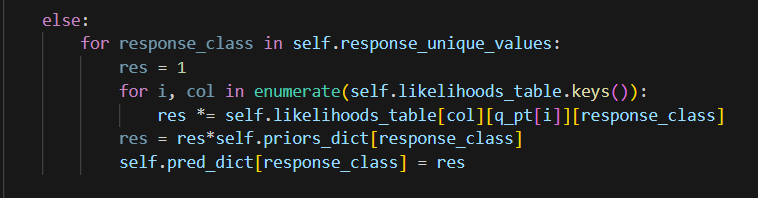


One problem whith the above equation is that of ***Numerical underflow*** which is a common issue that can occur when performing computations involving very small numbers. It arises due to the limited precision of numerical representations in computers. When numbers get too small, they can become rounded down to zero or lose significant digits, leading to inaccurate or unreliable results.

In our case we are multiplying probabilities multiple times (number of dimensions + 1 times), and because probabilities range from 0 to 1 the final number observed can be very small which can cause numerical underflow.

In order to address this issue, a logarithmic transformation is applied to our equation above to obtain the following equation:


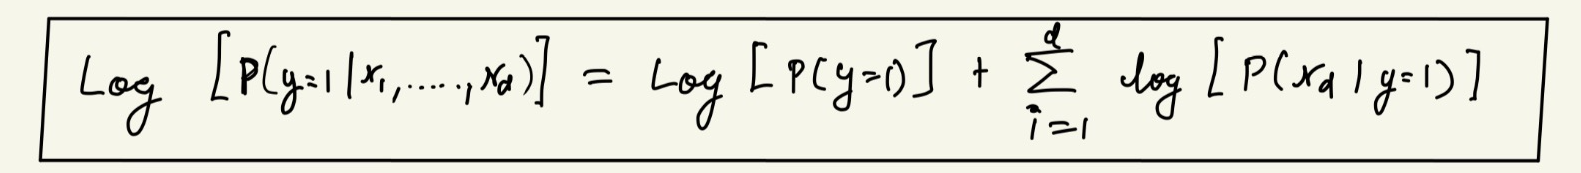


Below is the code to represent the same

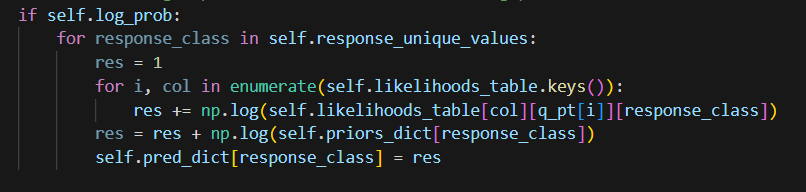

## Python Implementation

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_excel('./NB_DataSet.xlsx')
df

,Day,Outlook,Temperature,Humidity,Wind,Response
0,1,Sunny,Hot,High,Weak,No
1,2,Sunny,Hot,High,Strong,No
2,3,Overcast,Hot,High,Weak,Yes
3,4,Rain,Mild,High,Weak,Yes
4,5,Rain,Cool,Normal,Weak,Yes
5,6,Rain,Cool,Normal,Strong,No
6,7,Overcast,Cool,Normal,Strong,Yes
7,8,Sunny,Mild,High,Weak,No
8,9,Sunny,Cool,Normal,Weak,Yes
9,10,Rain,Mild,Normal,Weak,Yes


In [7]:
class Naive_Bayes_Categorical_Custom:
    def __init__(self, log_prob=False):
        self.log_prob = log_prob

    # Model Training
    def train(self, df, response_col):
        self.likelihoods_table = dict()
        self.priors_dict = dict()

        X_cols = list(df.columns)
        X_cols.remove(response_col)

        df_0 = df[df[response_col] == 'No']
        df_1 = df[df[response_col] == 'Yes']
        
        # table calculation
        for col in X_cols:
            self.likelihoods_table[col] = dict()
            distince_value = df[col].unique()
            for val in distince_value:
                prob_no = np.sum(df_0[col] == val) / df_0[col].shape[0]
                prob_yes = np.sum(df_1[col] == val) / df_1[col].shape[0]
                self.likelihoods_table[col][val] = {'No':prob_no, 'Yes':prob_yes}
        
        # calculating priors
        self.response_unique_values = df[response_col].unique()
        for val in self.response_unique_values:
            self.priors_dict[val] = np.sum(df[response_col] == val) / df.shape[0]



    def predict(self, q_pt):
        self.pred_dict = dict()
        self.pred_class = None

        # computing probabilities for different classes
        # both code in if and else statements are same with the diff of log implementation
        # in case of log implementation we will add the log probabilities instead of multiplying.
        if self.log_prob:
            for response_class in self.response_unique_values:
                res = 1
                for i, col in enumerate(self.likelihoods_table.keys()):
                    res += np.log(self.likelihoods_table[col][q_pt[i]][response_class])
                res = res + np.log(self.priors_dict[response_class])
                self.pred_dict[response_class] = res
        
        else:
            for response_class in self.response_unique_values:
                res = 1
                for i, col in enumerate(self.likelihoods_table.keys()):
                    res *= self.likelihoods_table[col][q_pt[i]][response_class]
                res = res*self.priors_dict[response_class]
                self.pred_dict[response_class] = res


        # selecting the pred class with max accuracy
        max_prob = self.pred_dict[response_class]
        self.pred_class = response_class
        for response_class in self.pred_dict.keys():
            if self.pred_dict[response_class] > max_prob:
                max_prob = self.pred_dict[response_class]
                self.pred_class = response_class

        return (self.pred_class, self.pred_dict)


nb1 = Naive_Bayes_Categorical_Custom(log_prob=False)
nb2 = Naive_Bayes_Categorical_Custom(log_prob=True)
nb1.train(df=df.iloc[:,1:], response_col='Response')
nb2.train(df=df.iloc[:,1:], response_col='Response')
q_pt = ['Sunny', 'Cool', 'High', 'Strong']


print('Likelihoods Table:')
for key in nb1.likelihoods_table.keys():
    print(key)
    print(nb1.likelihoods_table[key])

print('\n\nPredictions:')
print('Prediction without log_prob', nb1.predict(q_pt))
print('Prediction with log_prob', nb2.predict(q_pt))

Likelihoods Table:
Outlook
{'Sunny': {'No': 0.6, 'Yes': 0.2222222222222222}, 'Overcast': {'No': 0.0, 'Yes': 0.4444444444444444}, 'Rain': {'No': 0.4, 'Yes': 0.3333333333333333}}
Temperature
{'Hot': {'No': 0.4, 'Yes': 0.2222222222222222}, 'Mild': {'No': 0.4, 'Yes': 0.4444444444444444}, 'Cool': {'No': 0.2, 'Yes': 0.3333333333333333}}
Humidity
{'High': {'No': 0.8, 'Yes': 0.3333333333333333}, 'Normal': {'No': 0.2, 'Yes': 0.6666666666666666}}
Wind
{'Weak': {'No': 0.4, 'Yes': 0.6666666666666666}, 'Strong': {'No': 0.6, 'Yes': 0.3333333333333333}}


Predictions:
Prediction without log_prob ('No', {'No': 0.02057142857142857, 'Yes': 0.005291005291005291})
Prediction with log_prob ('No', {'No': -2.8838521284614496, 'Yes': -4.241747015059643})


In [8]:
# predicting on our train data

train_pred = []
y_pred_nb1 = []
y_pred_nb2 = []
for observation in df.iloc[:,1:-1].values:
    res1 = nb1.predict(observation)
    res2 = nb2.predict(observation)
    train_pred.append(res1)
    y_pred_nb1.append(res1[0])
    y_pred_nb2.append(res2[0])

y_pred_nb1 = np.array(y_pred_nb1)
print('Train Predictions for model without log_prob:\n', y_pred_nb1)
print('Train Predictions for model with log_prob:\n', y_pred_nb2)

Train Predictions for model without log_prob:
 ['No' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'No']
Train Predictions for model with log_prob:
 ['No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']


Text(531.1090909090908, 0.5, 'True Label')

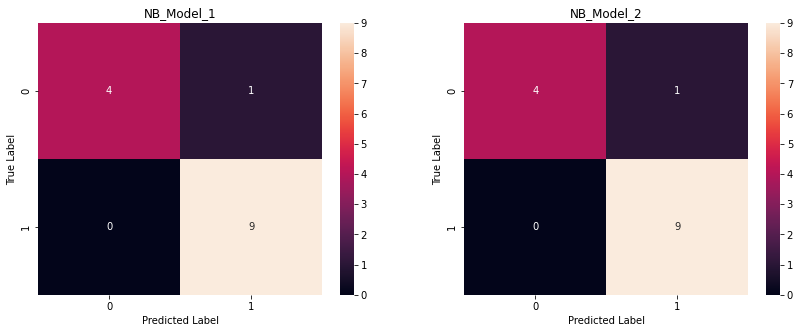

In [9]:
# plotting confusion matrix

from sklearn.metrics import confusion_matrix

plt.figure(1, figsize=(14,5))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(df['Response'], y_pred_nb1), annot=True)
plt.title('NB_Model_1')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(df['Response'], y_pred_nb2), annot=True)
plt.title('NB_Model_2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

## Conclusion

In conclusion, we have implemented Naive Bayes from scratch in Python. This implementation allows for categorical features, to address numerical features we can further utilizing Gaussian distribution assumptions for numerical features. The NaiveBayes class provides methods for training the model using the train function and making predictions on new instances using the predict function.

By training the model on labeled training data, we calculate the prior probabilities of each class and the conditional probabilities of feature values given each class. These probabilities are then used to predict the class label for new instances based on the observed feature values.

The implementation showcases the fundamental principles of Naive Bayes classification, including the calculation of probabilities, logarithmic transformation to avoid numerical underflow, and the selection of the class with the highest score as the predicted class.

